# Modeling Saturated Absorption Spectroscopy #

In this notebook we use the steady-state solver in rydiqule to model saturated absorption spectroscopy (SAS).
In SAS, a weak probing field and a strong counter-propagating pumping field probe transitions withing a Doppler-broadened atomic ensemble.
The probe field absorption is monitored as a function of frequency, while the pumping field produces sub-Doppler features due to the Lamb dip effect.

Modeling this experiment in rydiqule is not a trivial task and involves some key assumptions.
The difficulty lies in the fact that rydiqule does not allow multiple distinct fields in a single coupling.
In other words, every coupling in rydiqule must be expressed as a single field.
Normally, if you want to have two fields in a single coupling, you must define a single time-dependent field that then uses the time-solver.

In SAS, the probe and coupling fields only differ in their propagation, and therefore the sign of the Doppler shift the moving atoms see.
A full model of the system would require defining a time-dependent coupling where the frequencies of the two fields would depend on the velocity class being solved.
This is difficult to do in rydiqule and would be much slower than a steady-state model.

Here we make an approximate model of SAS that assumes a weak probe that does not influence the optical pumping of the system.
Under this assumption, we can solve the system assuming only the pump field is present, then look at the relevant ground state population as a proxy for the observed probe absorption.

This notebook can be downloaded [here](https://github.com/QTC-UMD/rydiqule/blob/main/docs/source/examples/Saturated_Absorption_Spectroscopy.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext line_profiler

In [3]:
import numpy as np
import rydiqule as rq
import matplotlib.pyplot as plt
from arc import Wigner6j

Start my defining the states of our manifolds. We use the string labeling of states so that we can use regex matching patterns when defining couplings later on.

Note that we do not consider the magnetic-sublevel structure here beyond accounting for appropriate level degeneracies.

In [4]:
g_list = [1,2]
e_list = [0,1,2,3]
g = ('g', g_list)
e = ('e', e_list)

This defines width of the Doppler distribution.

In [5]:
k = 1/780.24e-3
kb = 1.38e-23
mass = 1.41e-25
temp = 300
vP = np.sqrt(2*kb*temp/mass) # most probable speed, 3D
print(f'Most probable speed: {vP:.2f} m/s')

Most probable speed: 242.33 m/s


In [6]:
s = rq.Sensor([g,e], vP=vP)
print(s.states)
print(len(s.states))

[('g', 1), ('g', 2), ('e', 0), ('e', 1), ('e', 2), ('e', 3)]
6


We need to define the relative strength of the different hyperfine states. We use ARC's `Wigner6J` with Eq. 41 of Steck's Rubidium 87 D line Data. Note that these prefactors normalize as $\sum_{F'} S_{FF'} = 1$.

In [7]:
def Sff(J, F, Jp, Fp, I=3/2):
    
    return (2*Fp+1)*(2*J+1)*Wigner6j(J, Jp, 1, Fp, F, I)**2

Here we calculate the effective Clebsch-Gordon coefficients for the Pump couplings between the ground and excited states.

In [8]:
cg = {(('g',Fg), ('e', Fe)): Sff(1/2, Fg, 3/2, Fe)
      for Fg in g_list
      for Fe in e_list
      if Sff(1/2, Fg, 3/2, Fe) != 0.0
      }
print(f'There are {len(cg):d} total couplings')

There are 6 total couplings


We define a coupling group that maps our single coupling onto all the relevant couplings between the manifolds.

In [9]:
dets = np.linspace(-310, 250, 561)
rabi_freq = 6

k = 1/780.241e-3 #wavelength in um to get units right
kp = 2*np.pi*k*np.array([1,0,0])

s.add_coupling((g, e), rabi_frequency=2*np.pi*rabi_freq, detuning=2*np.pi*dets, coupling_coefficients=cg, kvec=kp, label='pump')

Here we define the "Clebsch-Gordon"-like coefficients, but for the dephasings between states.

In [10]:
g_manifold_degen = np.sum([2*F+1 for F in g_list])
cgg = {(('e',Fe), ('g', Fg)) : (2*Fg+1)/g_manifold_degen
       for Fe in e_list
       for Fg in g_list
      }
print(f'There are {len(cgg):d} total couplings')

There are 8 total couplings


In [11]:
gamma = 2*np.pi*6.0666
s.add_decoherence((e, g), gamma, coupling_coefficients=cgg, label='HFS_gamma')

Next, we define the hyperfine level shifts. The excited states are all defined relative to the center of mass frequency (ie the fine structure frequency).
The $F_g=1$ ground state is defined relative to the $F_g=2$ ground state.

In [12]:
hfs_shifts = {('e', 3): 2*np.pi*193.7407,
             ('e', 2): -2*np.pi*72.9112,
             ('e', 1): -2*np.pi*229.8518,
             ('e', 0): -2*np.pi*302.0738,
             ('g', 1): -2*np.pi*6834.682610904290}

In [13]:
s.add_energy_shifts(hfs_shifts)

Since this measurement is typically done in a vapor cell, we add transit broadening. 
In the doppler-free solve shown below, this prevents all population from being pumped into the stretch state.

In [14]:
s.add_transit_broadening(2*np.pi*0.1, repop={('g',Fg): (2*Fg+1)/g_manifold_degen for Fg in g_list})

In [15]:
%%time
solRb87D2 = rq.solve_steady_state(s)

CPU times: total: 375 ms
Wall time: 134 ms


In [16]:
pops = rq.get_rho_populations(solRb87D2)

In [17]:
pops.shape

(561, 6)

In [18]:
s.axis_labels()

['pump_detuning']

Text(0, 0.5, 'Population $F_g=2$')

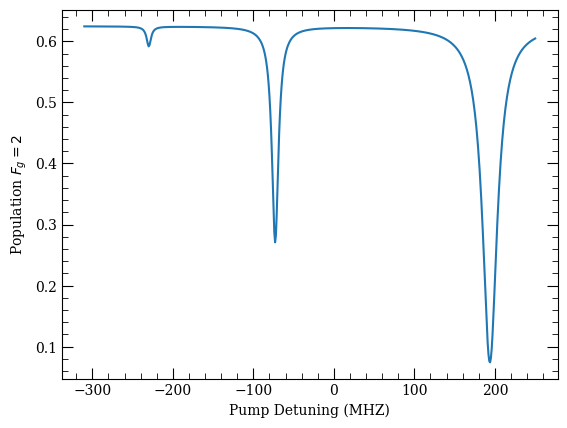

In [19]:
fig, ax = plt.subplots(1)

ax.plot(dets, pops[:,1])
ax.set_xlabel('Pump Detuning (MHZ)')
ax.set_ylabel('Population $F_g=2$')

We now solve the system with doppler shifts.
In order to correctly simulate SAS, we will not allow rydiqule to average the velocity classes together.
We have to do that ourselves.
We also provide a fixed, fine grid of velocity classes to solve for as a simplification of the analysis later on.

In [20]:
dops = np.linspace(-2.5,2.5,1201)
dop_meth = {'method':'direct', 'doppler_velocities':dops}

In [21]:
%%time
solRb87D2dop = rq.solve_steady_state(s, doppler=True, doppler_mesh_method=dop_meth, sum_doppler=False, weight_doppler=True)

CPU times: total: 11 s
Wall time: 9.88 s


In [22]:
dop_popFg2 = rq.get_rho_populations(solRb87D2dop)[:,:,1]

In [23]:
dop_popFg2.shape

(1201, 561)

Here we define the expected detunings of the observable hyperfine transitions and the cross-over peaks.

In [24]:
hfs_resonances = np.fromiter(hfs_shifts.values(), dtype=float)[:-1]
print(hfs_resonances)
co_pairs = [(0,1),(1,2),(0,2)]
co_resonances = np.array([(hfs_resonances[i]+hfs_resonances[j])/2 for (i,j) in co_pairs])
print(co_resonances)

[ 1217.30871964  -458.11458057 -1444.20145259 -1897.98566184]
[ 379.59706954 -951.15801658 -113.44636647]


(-310.0, 250.0)

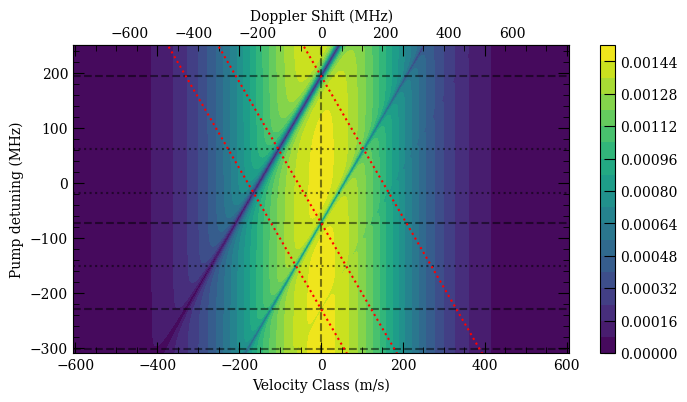

In [25]:
fig, ax = plt.subplots(1, figsize=(8,4))

D, V = np.meshgrid(dets, dops*vP)

CS = ax.contourf(V, D, dop_popFg2, levels=20)
CB = fig.colorbar(CS, ax=ax, orientation='vertical')

def VtoMHz(v):
    return v*k

def MHztoV(MHz):
    return MHz/k

secax = ax.secondary_xaxis('top', functions=(VtoMHz, MHztoV))
secax.set_xlabel('Doppler Shift (MHz)')

for res in hfs_resonances:
    ax.axhline(res/2/np.pi, c='k', ls='--', alpha=0.5)

for co in co_resonances:
    ax.axhline(co/2/np.pi, c='k', ls=':', alpha=0.5)
    
ax.axvline(0, c='k', ls='--', alpha=0.5)
    
probe_res = -k*dops*vP
for res in hfs_resonances[:-1]:
    ax.plot(dops*vP, probe_res + res/2/np.pi, 'r:')

ax.set_xlabel('Velocity Class (m/s)')
ax.set_ylabel('Pump detuning (MHz)')
ax.set_ylim((dets.min(), dets.max()))

In the above plot, we show the population of the $F_g=2$ ground state versus velocity class and pump detuning. 
The depleted $F_g=2$ populations corresponding to resonances with the $F_e=(1,2,3)$ excited states can be seen as lines with positive slope.
The horizontal gray dashed lines are the 0 velocity class resonances for the $F_g=2, F_e=(1,2,3)$ transitions.
The horizontal gray dotted lines are the cross-over peak locations.

The red dotted lines show the same transition resonances visible in the population depletion, but for the counter-propagating probe (which experiences the opposite doppler shift).

Our counter-propagating probe, if sufficiently weak, does not influence the $F_g=2$ ground state population itself.
Therfore, its absorption is proportional to the $F_g=2$ population in the velocity classes that have resonant couplings to excited states.
In other words, it can only probe ground state population using a dipole-allowed transition, and which velocity classes satisfy that condition depends on overall detuning of the probe/pump.

Therefore, we need to sample our doppler solves above for the resonant velocity classes as a function of detuning (ie the red dotted lines).

$$ \delta = f_i - kv $$

We also want to account for the fact the probing transition is finite width, and weight nearby velocity classes by the lorentzian response.

In [26]:
dop_shift_step = np.diff(dops*vP*k)[0]
print(f'Velocity class step size {dop_shift_step:.3f} MHz')

Velocity class step size 1.294 MHz


In [27]:
def lorentzian(f, f0, Γ):
    return 1/np.pi*(Γ/2)/((f-f0)**2 + (Γ/2)**2)

In [28]:
lor_window = np.linspace(-10, 10, 25)
print(lor_window)

[-10.          -9.16666667  -8.33333333  -7.5         -6.66666667
  -5.83333333  -5.          -4.16666667  -3.33333333  -2.5
  -1.66666667  -0.83333333   0.           0.83333333   1.66666667
   2.5          3.33333333   4.16666667   5.           5.83333333
   6.66666667   7.5          8.33333333   9.16666667  10.        ]


We calculate the weighting factors, and confirm they sum to approximately 1.
Note that the doppler sampling is fairly course relative to the transition's linewidth, so our sampling will always be rough.

In [29]:
lor_weights = lorentzian(lor_window, 0, gamma/2/np.pi)
print(np.sum(lor_weights))

0.9836287684107903


In [30]:
resonances = hfs_resonances[:-1]/2/np.pi
print(resonances)
probe_classes_norm = (resonances[:,None,None] - dets[None,None,:] + lor_window[None,:,None])/k/vP
print(probe_classes_norm.shape)

[ 193.7407  -72.9112 -229.8518]
(3, 25, 561)


Need to find the closest solved velocity class for each resonant point.

In [31]:
def find_closest_ind(x):
    
    min_ind = np.argmin(np.abs(dops-x))
    
    return min_ind
    
np_find_closest_ind = np.vectorize(find_closest_ind)

In [32]:
res_inds = np_find_closest_ind(probe_classes_norm)
print(res_inds.shape)

(3, 25, 561)


Now we slice out the relevant velocity classes for each detuning, weight them, and sum.

In [33]:
SAS_pops = dop_popFg2[res_inds,np.arange(len(dets))]  # selects indeces along doppler axis for each detuning
print(SAS_pops.shape)
SAS_weighted_pops = SAS_pops*lor_weights[None,:,None] # weight the classes near each resonance by the lorentzian response of the probe
SAS_probe = np.sum(SAS_weighted_pops, axis=(0,1))
print(SAS_probe.shape)

(3, 25, 561)
(561,)


Text(0.5, 1.0, 'Rb$^{87}$ $F_g=2\\rightarrow F_e=(1,2,3)$')

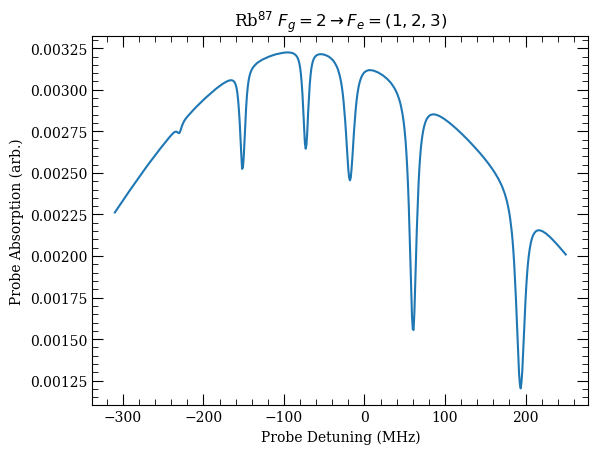

In [34]:
fig, ax = plt.subplots(1)

ax.plot(dets, SAS_probe)
ax.set_xlabel('Probe Detuning (MHz)')
ax.set_ylabel('Probe Absorption (arb.)')
ax.set_title('Rb$^{87}$ $F_g=2\\rightarrow F_e=(1,2,3)$')

In [35]:
rq.about()


        Rydiqule
    
Rydiqule Version:     2.1.0.dev11+gf4e837b.d20250222
Installation Path:    ~\src\Rydiqule\src\rydiqule

      Dependencies
    
NumPy Version:        1.26.4
SciPy Version:        1.12.0
Matplotlib Version:   3.8.0
ARC Version:          3.6.0
Python Version:       3.11.8
Python Install Path:  ~\Miniconda3\envs\rq
Platform Info:        Windows (AMD64)
CPU Count and Freq:   12 @ 3.60 GHz
Total System Memory:  128 GB
